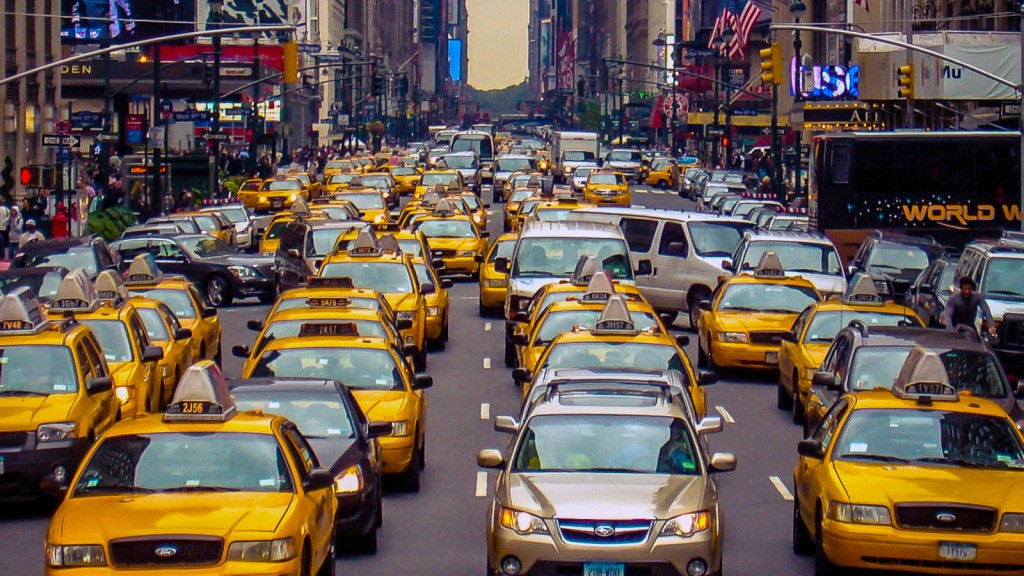

# AML PROJECT
## Obiettivo
Lo scopo di questo progetto è quello di prevedere la durata di un viaggio in taxi nella città di New York a partire da una serie di informazioni rilasciate dalla NYC Taxi and Limousine Commission, che include l'orario di prelievo, le coordinate geografiche di partenza e arrivo, il numero di passeggeri e molte altre variabili.

## Introduzione (copiata da altri ragazzi! MODIFICARE)
Nelle città densamente popolate è importante ma difficile prevedere la durata di un viaggio a causa del traffico; in particolare, lo scopo di questo progetto è conoscere la durata di un viaggio in taxi a New York a partire
da una serie di informazioni riguardanti i dati geospaziali di partenza e arrivo, il numero di passeggeri e le informazioni sul periodo in cui viene effettuato il viaggio.
Una delle possibili applicazioni è aiutare l'utente a prevedere la durata del suo viaggio in taxi in anticipo al momento della prenotazione.
L'approccio a questo tipo di problema è stato quello di integrare le informazioni riguardanti l'area in cui il viaggio si svolge in quanto possono esserci variazioni di tempo molto ampie in base al luogo; per creare dati
arricchimento e avere più funzionalità disponibili su cui addestrare una rete neurale. La scelta di utilizzare le reti neurali sono state realizzate perché c'è un numero molto elevato di dati e questi algoritmi lo consentono
per trovare facilmente relazioni non lineari tra le variabili di input.

# Importo le librerie e i pacchetti necessari

In [2]:
!pip install haversine
!pip install geopandas

In [3]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

import matplotlib.pyplot as plt
import seaborn as sns 

from haversine import haversine

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium

import datetime
from datetime import timedelta

import scipy.stats as stats

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# Importo i dati

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/MAGISTRALE/2 anno/1 semestre/advanced machine learning/TAXI')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')


Il dataset è stato preso da kaggle [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration). Procediamo con la descrizione della struttura del dataset e con le scelte fatte per avere dati più utili.

#info varie sul dataset

In [6]:
print(train.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')


In [7]:
print(test.columns)
#Obviously dropoff_datetime and trip_duration are only available for the train set.

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')


In [8]:
print(train.shape)
print(test.shape)

(1458644, 11)
(625134, 9)


**Descrizione del dataset**  
Il set di dati contiene i dati relativi a diversi viaggi in taxi e alla loro durata a New York City. Proveremo ora ad applicare diverse tecniche di analisi dei dati per ottenere informazioni sui dati e determinare come le diverse variabili dipendono dalla variabile target Durata del viaggio.

**Descrizioni file:**  
taxi_train.csv - il train set (contiene 1458644 record di viaggio)

**Campi dati:**  
- id: un identificatore univoco per ogni viaggio.  
- vendor_id - un codice che indica il fornitore associato al record del viaggio
- pickup_datetime - data e ora in cui lo strumento è stato attivato.
- dropoff_datetime - data e ora in cui lo strumento è stato disattivato.
- passenger_count - il numero di passeggeri nel veicolo (valore inserito dal conducente).
- pickup_longitude - la longitudine in cui è stato attivato lo strumento.
- pickup_latitude - la latitudine in cui è stato attivato lo strumento.
- dropoff_longitude - la longitudine in cui lo strumento è stato disattivato.
- dropoff_latitude - la latitudine in cui lo strumento è stato disattivato.
- store_and_fwd_flag - Questo flag indica se il record del viaggio era conservato nella memoria del veicolo prima dell'invio perché il veicolo non aveva una connessione al server - Y = salva e inoltra; N = non è stato salvato.
- trip_duration - durata del viaggio in secondi.

In [9]:
print(train.info())
#We have 1458644 observations, 11 features, and our target variable is trip_duration
#there are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None


In [10]:
#check to ensure all trips are valid
sum(train.dropoff_datetime < train.pickup_datetime)

0

In [11]:
# There are no duplicated rows
train.duplicated().sum()

0

In [12]:
#change format date column
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'])

# Cleaning the Data

In [13]:
# drop feature since it will not be used to make any predictions.
# it is not included in the test dataframe
train = train.drop('dropoff_datetime',1)

#analizzo variabile per variabile


## vendor_id

In [14]:
#Checking no. of vendors
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [15]:
train.groupby('vendor_id')['trip_duration']

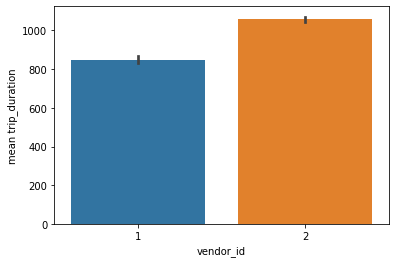

In [16]:
#group by vendor_id and we average the duration of the trip for the two classes
sns.barplot(train['vendor_id'], train['trip_duration'], ci=99)
plt.ylabel('mean trip_duration');

Il dataset è bilanciato rispetto alla feature 'vendor_id'. Sembra che il fornitore con codice 2 compia viaggi con durata media più lunga e la differenza sembra essere significativa. Per essere certi di questa affermazione bisogna prima però rimuovere gli outliers.

In [17]:
#One-hot encoding
train = pd.concat([train, pd.get_dummies(train['vendor_id'], prefix='vendor_id')], axis=1)
test = pd.concat([test, pd.get_dummies(test['vendor_id'], prefix='vendor_id')], axis=1)

train.drop(['vendor_id'], axis=1, inplace=True)
test.drop(['vendor_id'], axis=1, inplace=True)

##trip_duration

In [18]:
train.trip_duration.describe()
#some trips are very long, there are outliers!

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

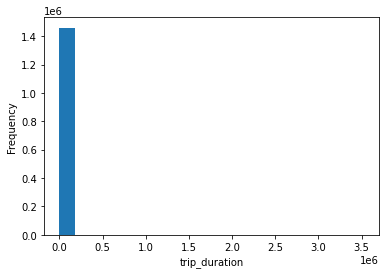

In [19]:
train['trip_duration'].plot(kind='hist', bins=20)
plt.xlabel('trip_duration');

Questo istogramma mostra una forte asimmetria destra, quindi ci sono outliers. Vediamo il boxplot di questa variabile.

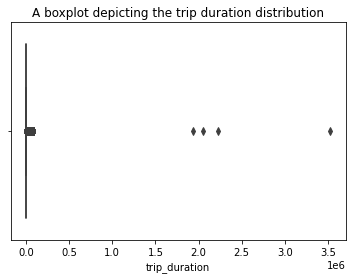

In [20]:
sns.boxplot(train['trip_duration'])
plt.title('A boxplot depicting the trip duration distribution');

Possiamo vedere che ci sono un po' di valori anomali, che dobbiamo trattare.

In [21]:
# Check how many trips remain
print('with 99.5 percentile: remain {} data on {} (remove {} data)'
        .format(len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.5)]), len(train),
                len(train)-len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.5)])))
print('with 99.7 percentile: remain {} data on {} (remove {} data)'
        .format(len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.7)]), len(train),
                len(train)-len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.7)])))
print('with 99.9 percentile: remain {} data on {} (remove {} data)'
        .format(len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.9)]), len(train),
                len(train)-len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.9)])))

with 99.5 percentile: remain 1451352 data on 1458644 (remove 7292 data)
with 99.7 percentile: remain 1454268 data on 1458644 (remove 4376 data)
with 99.9 percentile: remain 1457185 data on 1458644 (remove 1459 data)


In [22]:
print('There are {} trip with duration less than 10 seconds'.format(train[train.trip_duration <= 10].count()[0]))
print('There are {} trip with duration less than 30 seconds'.format(train[train.trip_duration <= 30].count()[0]))
print('There are {} trip with duration less than 60 seconds'.format(train[train.trip_duration <= 60].count()[0]))

There are 2166 trip with duration less than 10 seconds
There are 4890 trip with duration less than 30 seconds
There are 8777 trip with duration less than 60 seconds


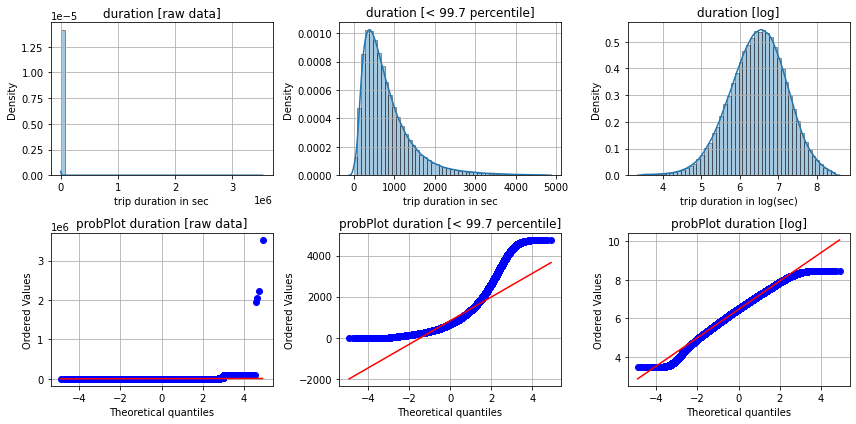

In [23]:
fig,sub = plt.subplots(2,3,figsize=(12,6))

sns.distplot(train.trip_duration,
             hist_kws={"edgecolor":"black"}, ax=sub[0][0])
sns.distplot(train[train.trip_duration <= np.percentile(train.trip_duration, 99.7)]["trip_duration"],
             hist_kws={"edgecolor":"black"}, ax=sub[0][1])
sns.distplot(np.log1p(train[(train.trip_duration <= np.percentile(train.trip_duration, 99.7)) & (train.trip_duration > 30)]["trip_duration"]),
             hist_kws={"edgecolor":"black"}, ax=sub[0][2])


prob = stats.probplot(train.trip_duration,
                      dist=stats.norm, plot=sub[1][0])
prob = stats.probplot(train[train.trip_duration <= np.percentile(train.trip_duration, 99.7)]["trip_duration"],
                      dist=stats.norm, plot=sub[1][1])
prob = stats.probplot(np.log1p(train[(train.trip_duration <= np.percentile(train.trip_duration, 99.7)) & (train.trip_duration > 30)]["trip_duration"]),
                      dist=stats.norm, plot=sub[1][2])

counter = 0

for name, subplot in zip(["duration [raw data]", "duration [< 99.7 percentile]", "duration [log]",
                          "probPlot duration [raw data]", "probPlot duration [< 99.7 percentile]", "probPlot duration [log]"], sub.flatten()):
    subplot.set_title("{}".format(name))
    subplot.grid()
    if counter < 3:
        if name == "duration [log]": 
            subplot.set_xlabel("trip duration in log(sec)")
        else:
            subplot.set_xlabel("trip duration in sec")
    counter += 1

plt.tight_layout()

Decidiamo di rimuovere lo 0.3% di viaggi con durata più elevata e quelli con durata inferiore ai 30 secondi.  
Come mostra il grafico, quando andremo a costruire il modello converrà applicare una trasformazione logaritmica alla variabile target così che abbia una distribuzione normale .

In [24]:
# Remove outliers
train = train[(train.trip_duration <= np.percentile(train.trip_duration, 99.7)) & (train.trip_duration > 30) ]

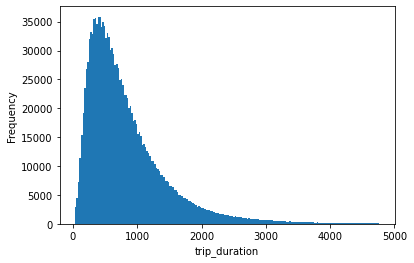

In [25]:
train['trip_duration'].plot(kind='hist', bins=200)
plt.xlabel('trip_duration');

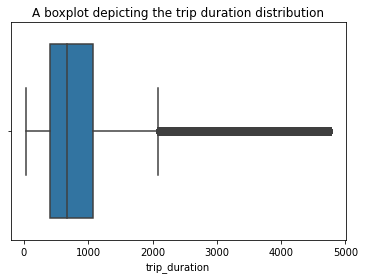

In [26]:
sns.boxplot(train['trip_duration'])
plt.title('A boxplot depicting the trip duration distribution');

##DISTANCE
Ci sono delle osservazioni che hanno stesso punto di partenza e di arrivo. Potrebbero indicare dei viaggi in taxi panoramici, per visitare la città. Decidiamo di eliminare tali osservazioni.

In [27]:
len(train[(train.pickup_longitude == train.dropoff_longitude) & (train.pickup_latitude == train.dropoff_latitude)])

4544

In [28]:
train=train[(train.pickup_longitude != train.dropoff_longitude) | (train.pickup_latitude != train.dropoff_latitude)]

Adesso calcoliamo la distanza tra il punto di partenza e quello di arrivo. Ci sono diversi modi per farlo.

In [29]:
#Euclidean distance
train['euclidean_distance'] = np.sqrt( np.power(train['dropoff_longitude'] - train['pickup_longitude'], 2) + 
                                  np.power(train['dropoff_latitude'] - train['pickup_latitude'], 2))
test['euclidean_distance'] = np.sqrt( np.power(test['dropoff_longitude'] - test['pickup_longitude'], 2) + 
                                  np.power(test['dropoff_latitude'] - test['pickup_latitude'], 2))

In [30]:
#Haversine distance
train['haversine_distance'] = train.apply(lambda x: haversine((x.pickup_latitude,x.pickup_longitude),(x.dropoff_latitude,x.dropoff_longitude)),axis=1)
test['haversine_distance'] = test.apply(lambda x: haversine((x.pickup_latitude,x.pickup_longitude),(x.dropoff_latitude,x.dropoff_longitude)),axis=1)

In [31]:
#Manhattan distance
train['manhattan_distance'] =(abs(train.dropoff_longitude - train.pickup_longitude) +
                              abs(train.dropoff_latitude - train.pickup_latitude))
test['manhattan_distance'] =(abs(test.dropoff_longitude - test.pickup_longitude) +
                              abs(test.dropoff_latitude - test.pickup_latitude))

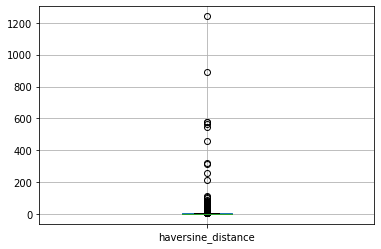

In [32]:
#Visualize distance outliers
train.boxplot(column='haversine_distance', return_type='axes');

In [33]:
len(train[(train.haversine_distance >= 80)])

16

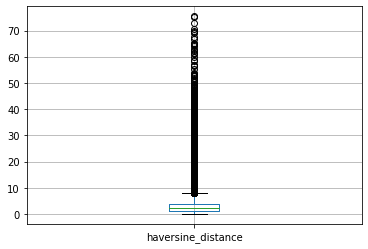

In [34]:
#Remove distance outliers
train = train[(train.haversine_distance < 80)]

train.boxplot(column='haversine_distance', return_type='axes');

Teniamo solo quei viaggi che coprono una distanza in linea d'area inferiore agli 80 km.  
Per costruire il modello utilizzeremo la distanza 'haversine' cioè la distanzain linea d'area in km tra due punti sulla superficie terrestre. Siamo consapevoli che questa misura introduce un bias in quanto sottostima la vera distanza percorsa dai taxi in modo differente a seconda della lunghezza del percorso. Introduciamo quindi una nuova variabile categorica in riferimento alla lunghezza del tragitto.  

In [35]:
#data binning
def distance_group(df):
  group = []
  for row in df['haversine_distance']:
      if row < 3:
          group.append('short')
      elif row < 10:
          group.append('medium')
      elif row < 30:
          group.append('medium -long')
      else:
          group.append('long')
  return group

In [36]:
train['distance_group'] = distance_group(train)
test['distance_group'] = distance_group(test)

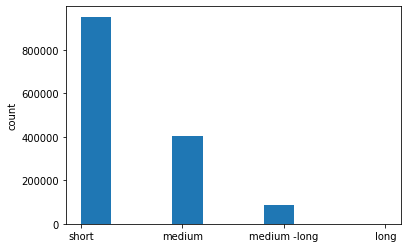

In [37]:
plt.hist(train['distance_group'])
plt.ylabel('count');

In [38]:
#One-hot encoding
train = pd.concat([train, pd.get_dummies(train['distance_group'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['distance_group'])], axis=1)

train.drop(['distance_group'], axis=1, inplace=True)
test.drop(['distance_group'], axis=1, inplace=True)

##pickup_datetime

In [39]:
#Checking Date and Time range
print('Datetime range: {} to {}'.format(train.pickup_datetime.min(),train.pickup_datetime.max()))

Datetime range: 2016-01-01 00:00:17 to 2016-06-30 23:59:39


Il dataset contiene osservazioni dal 2016-01-01 al 2016-06-30.  
Creo delle nuove variabili che potrebbero essere utili per costruire il modello.

In [40]:
#Date features creations and deletions for train set
train['month'] = train.pickup_datetime.dt.month
train['week'] = train.pickup_datetime.dt.week
train['weekday'] = train.pickup_datetime.dt.weekday
train["day"] = train["pickup_datetime"].dt.day
train['hour'] = train.pickup_datetime.dt.hour
train['minute'] = train.pickup_datetime.dt.minute
train['minute_oftheday'] = train['hour'] * 60 + train['minute']
train.drop(['minute'], axis=1, inplace=True)

In [41]:
#Date features creations and deletions for test set
test['month'] = test.pickup_datetime.dt.month
test['week'] = test.pickup_datetime.dt.week
test['weekday'] = test.pickup_datetime.dt.weekday
test["day"] = test["pickup_datetime"].dt.day
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test['minute_oftheday'] = test['hour'] * 60 + test['minute']
test.drop(['minute'], axis=1, inplace=True)

Text(0, 0.5, 'number of trip')

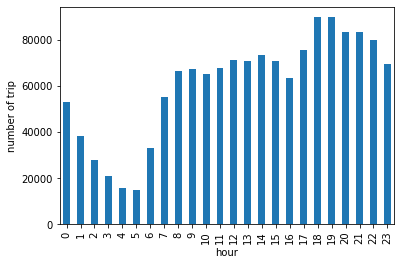

In [42]:
#number of trip by hour
train.groupby('hour')['id'].count().plot(kind='bar')
plt.ylabel('number of trip')

#majority of the trip has been booked from 6PM to 10PM.

Il numero totale di viaggi effettuati (e quindi il traffico) dipende in larga misura dall'ora del giorno. Proprio per questo nel modello utilizzeremo delle variabili che indicano il periodo della giornata in cui è iniziato il viaggio.

In [43]:
# - Early morning (4 hrs to 8 hrs)
# - Morning (8 hrs to 12 hrs) , 
# - Afternoon (12 hrs to 17 hrs) , 
# - Evening (17 hrs to  20 hrs),
# - Night (20 hrs to 0 hrs)
# - Mid night (0 hrs to 4hrs)

def period(a):
    if a in range(0,4):
        return 'Mid night'
    elif a in range(4,8):
        return "Early morning"
    elif a in range(8,12):
        return "Morning"
    elif a in range(12,17):
        return "Afternoon"
    elif a in range(17,20):
        return "Evening"
    else:
        return "Night"

train['pickup_timezone'] = train.apply(lambda x: period(x['pickup_datetime'].hour),axis=1)
test['pickup_timezone'] = test.apply(lambda x: period(x['pickup_datetime'].hour),axis=1)

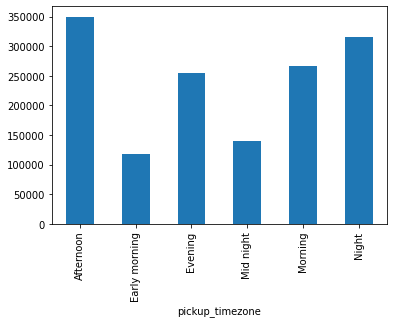

In [44]:
#number of trip by timezone
train.groupby('pickup_timezone')['pickup_timezone'].count().plot(kind='bar');

Un'approccio alternativo a quello di dividere la giornata in 6 periodi in base all'ora, è quello di raggruppare i viaggi in gruppi ordinati per KMeans. Questo dovrebbe aiutare i viaggi nelle "ore di punta" ad essere negli stessi gruppi.


In [45]:
# Rather than use the standard 24 hours, group the trips into 6 groups that are sorted by KMeans
# This should help 'rush-hour' rides to be in the same groups
kmeans_pickup_time = KMeans(n_clusters=6, random_state=2).fit(train.minute_oftheday.values.reshape(-1,1))

In [46]:
train['kmeans_timezone'] = kmeans_pickup_time.predict(train.minute_oftheday.values.reshape(-1,1))
test['kmeans_timezone'] = kmeans_pickup_time.predict(test.minute_oftheday.values.reshape(-1,1))

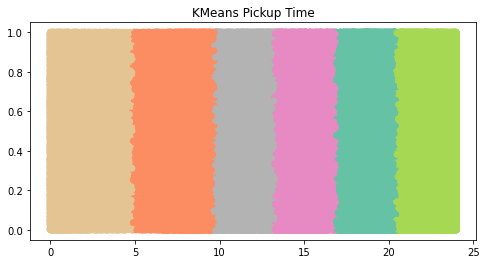

In [47]:
# distribution of kmeans_pickup_time
f, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 4))

ax.scatter(x = train.minute_oftheday/60, 
            y = np.random.uniform(0,1, len(train)), 
            cmap = 'Set2', c = train.kmeans_timezone)
scatter=ax.set_title('KMeans Pickup Time');

In [48]:
#One-hot encoding
train = pd.concat([train, pd.get_dummies(train['kmeans_timezone'], prefix='kmeans_timezone')], axis=1)
test = pd.concat([test, pd.get_dummies(test['kmeans_timezone'], prefix='kmeans_timezone')], axis=1)

train.drop(['kmeans_timezone'], axis=1, inplace=True)
test.drop(['kmeans_timezone'], axis=1, inplace=True)

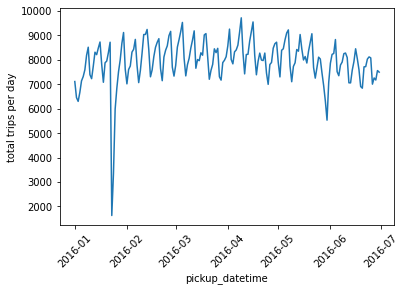

In [49]:
#trip per day
trip_per_day = train.groupby(train['pickup_datetime'].dt.date)['id'].count()
trip_per_day.plot(ylabel='total trips per day')
plt.xticks(rotation=45);

In [50]:
trip_per_day.idxmin()

datetime.date(2016, 1, 23)

C'è un valore anomalo il 23/01/2016. è probabile che si sia verificato un problema nella procedura di registrazione.  
Anche a giugno c'è stato un notevole calo, con un picco con meno di 6000 viaggi.

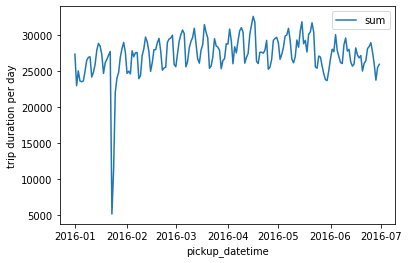

In [51]:
trip_duration_per_day = train.groupby(train['pickup_datetime'].dt.date)['haversine_distance'].agg(['sum'])
trip_duration_per_day.plot(ylabel='trip duration per day');
#most trips are in the range of 25000 to 32000.

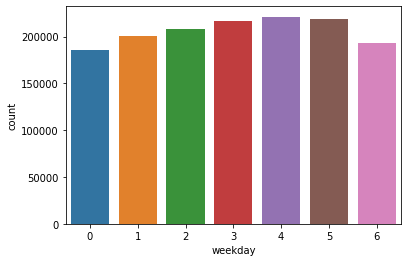

In [52]:
#Plotting daily Pickup trip distribution
sns.countplot(x='weekday',data=train);
#We can see most trips were taken on Friday & least trips were taken on Monday.

Il traffico dipende dal giorno della settimana in cui viene effettuato il viaggio.

### creo variabile festività


In [53]:
# Load a list of holidays in the US
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

# Load business days
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.date_range(start = '2016-01-01', 
                                 end = '2016-06-30', 
                                 freq = us_bd)
business_days = pd.to_datetime(business_days).date

In [54]:
train['is_weekend'] = train.weekday.map(lambda x: 1 if x >= 5 else 0)
train['businessday'] = pd.to_datetime(train.pickup_datetime.dt.date).isin(business_days)
train['businessday'] = train.businessday.map(lambda x: 1 if x == True else 0)
train['holiday'] = pd.to_datetime(train.pickup_datetime.dt.date).isin(holidays)
train['holiday'] = train.holiday.map(lambda x: 1 if x == True else 0)

In [55]:
test['is_weekend'] = test.weekday.map(lambda x: 1 if x >= 5 else 0)
test['businessday'] = pd.to_datetime(test.pickup_datetime.dt.date).isin(business_days)
test['businessday'] = test.businessday.map(lambda x: 1 if x == True else 0)
test['holiday'] = pd.to_datetime(test.pickup_datetime.dt.date).isin(holidays)
test['holiday'] = test.holiday.map(lambda x: 1 if x == True else 0)

##passenger_count

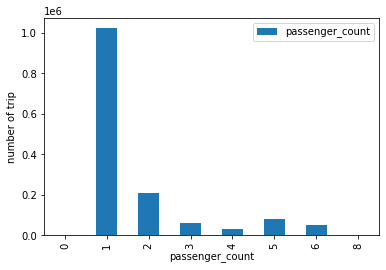

In [56]:
train.groupby('passenger_count')[['passenger_count']].count().plot(kind='bar')
plt.ylabel('number of trip');

La maggior parte dei viaggi è effettuta con 1 o 2 passeggeri. Il caso di un grande gruppo di persone che viaggiano insieme è raro.

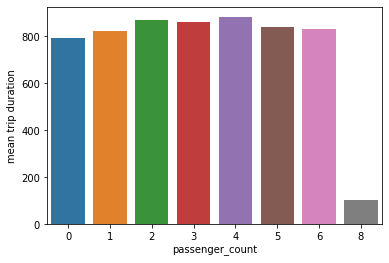

In [57]:
#relationship between passengers and trip time
pc = train.groupby('passenger_count')['trip_duration'].mean()
sns.barplot(pc.index,pc.values)
plt.ylabel('mean trip duration');

In [58]:
print('How many trips were made with 0 passengers?', len(train[train['passenger_count']==0]))
print('How many trips were made with 7 passengers?', len(train[train['passenger_count']==7]))
print('How many trips were made with 8 passengers?', len(train[train['passenger_count']==8]))
print('How many trips were made with 9 passengers?', len(train[train['passenger_count']==9]))

How many trips were made with 0 passengers? 21
How many trips were made with 7 passengers? 0
How many trips were made with 8 passengers? 1
How many trips were made with 9 passengers? 0


In [59]:
#Remove trip with 0, 7, 8, 9 passengers (25 data)
train = train[(train.passenger_count <= 6) & (train.passenger_count > 0) ]

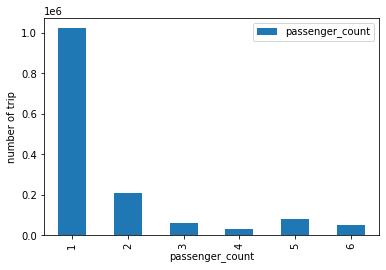

In [60]:
train.groupby('passenger_count')[['passenger_count']].count().plot(kind='bar')
plt.ylabel('number of trip');

##pickup/dropoff latitude and longitude

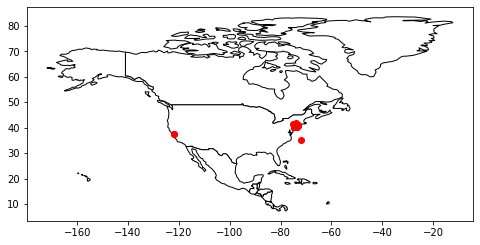

In [61]:
geometry = [Point(xy) for xy in zip(train['pickup_longitude'], train['pickup_latitude'])]
gdf = GeoDataFrame(train, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black',figsize=(8, 8))

gdf.plot(ax=ax, color='red');
#there are outliers!

In [62]:
# Find limits of location
max_value = 99.999
min_value = 0.001

In [63]:
len(train)

1444796

In [64]:
# Remove extreme values
train = train[(train.pickup_latitude <= np.percentile(train.pickup_latitude, max_value)) & 
              (train.pickup_latitude >= np.percentile(train.pickup_latitude, min_value))]
train = train[(train.pickup_longitude <= np.percentile(train.pickup_longitude, max_value)) & 
              (train.pickup_longitude >= np.percentile(train.pickup_longitude, min_value))]

train = train[(train.dropoff_latitude <= np.percentile(train.dropoff_latitude, max_value)) & 
              (train.dropoff_latitude >= np.percentile(train.dropoff_latitude, min_value))]
train = train[(train.dropoff_longitude <= np.percentile(train.dropoff_longitude, max_value)) & 
              (train.dropoff_longitude >= np.percentile(train.dropoff_longitude, min_value))]

In [65]:
len(train)
#remove 120 rows

1444676

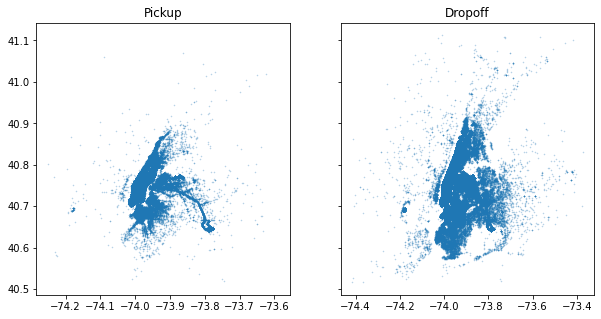

In [66]:
# Plot locations - look for outliers
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(train.pickup_longitude, train.pickup_latitude, alpha = 0.3, s=0.3)
ax1.set_title('Pickup')

ax2.scatter(train.dropoff_longitude, train.dropoff_latitude, alpha = 0.3, s=0.3)
ax2.set_title('Dropoff');

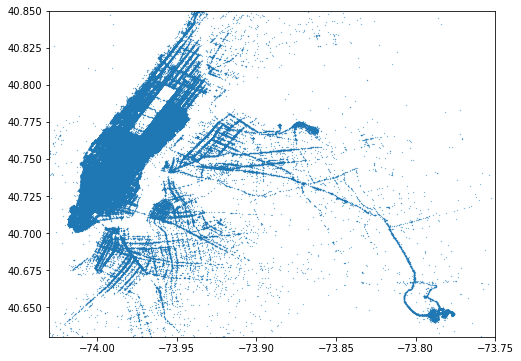

In [67]:
#Visualizing Passenger road map for picking up
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(8,6))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
ax.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.05, alpha=1);

Si vedono chiaramente le principale strade di New York. In basso a destra nel grafico (coordinate 40.650, -73.80) c'è l'areoporto.

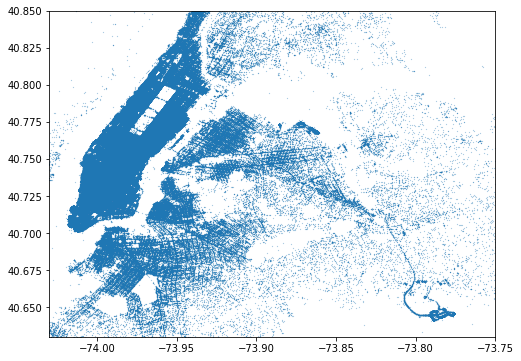

In [68]:
#Visualizing Passenger road map for dropoff
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(8,6))
plt.ylim(40.63, 40.85)
plt.xlim(-74.03,-73.75)
ax.scatter(train['dropoff_longitude'],train['dropoff_latitude'], s=0.02, alpha=1);

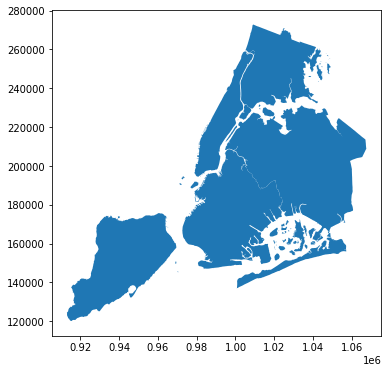

In [69]:
#Getting New York City map from Geopandas
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
ax = nyc.plot(figsize=(6, 6))

In [70]:
#Map where the passengers have been picked up (blue) and dropped off (red)
f = folium.Figure(width=500, height=300)
mapa = folium.Map(location = (40.7679, -73.9822), zoom_start=11).add_to(f)

for index, row in train.sample(100).iterrows():
    folium.Marker([row["pickup_latitude"], row["pickup_longitude"]], icon=folium.Icon(color="blue")).add_to(mapa)
    folium.Marker([row["dropoff_latitude"], row["dropoff_longitude"]], icon=folium.Icon(color="red")).add_to(mapa)

display(mapa)

### raggruppo per zona geografica tramite kmeans

In [71]:
# Group pickup and dropoff locations into 8 groups
kmeans_dropoff = KMeans(n_clusters=8, random_state=2).fit(train[['dropoff_latitude','dropoff_longitude']][:500000])

train['kmeans_pickup'] = kmeans_dropoff.predict(train[['pickup_latitude','pickup_longitude']])
train['kmeans_dropoff'] = kmeans_dropoff.predict(train[['dropoff_latitude','dropoff_longitude']])

In [72]:
test['kmeans_pickup'] = kmeans_dropoff.predict(test[['pickup_latitude','pickup_longitude']])
test['kmeans_dropoff'] = kmeans_dropoff.predict(test[['dropoff_latitude','dropoff_longitude']])

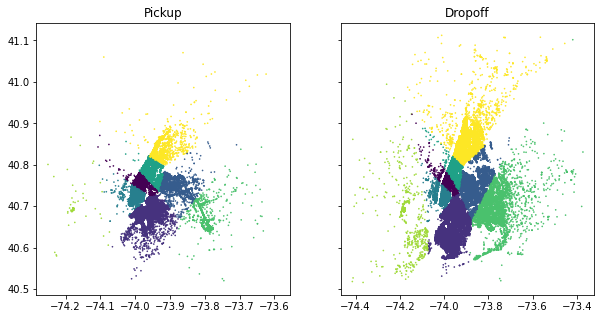

In [73]:
# Plot these 8 groups
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(train.pickup_longitude, train.pickup_latitude,
            cmap = 'viridis', c = train.kmeans_pickup, s=0.4)
ax1.set_title('Pickup')
ax2.scatter(train.dropoff_longitude, train.dropoff_latitude, 
            cmap = 'viridis', c = train.kmeans_dropoff, s=0.4)
ax2.set_title('Dropoff');

In [74]:
#One-hot encoding - pickup
train = pd.concat([train, pd.get_dummies(train['kmeans_pickup'], prefix='kmeans_pickup')], axis=1)
test = pd.concat([test, pd.get_dummies(test['kmeans_pickup'], prefix='kmeans_pickup')], axis=1)

train.drop(['kmeans_pickup'], axis=1, inplace=True)
test.drop(['kmeans_pickup'], axis=1, inplace=True)

In [75]:
#One-hot encoding - dropoff
train = pd.concat([train, pd.get_dummies(train['kmeans_dropoff'], prefix='kmeans_dropoff')], axis=1)
test = pd.concat([test, pd.get_dummies(test['kmeans_dropoff'], prefix='kmeans_dropoff')], axis=1)

train.drop(['kmeans_dropoff'], axis=1, inplace=True)
test.drop(['kmeans_dropoff'], axis=1, inplace=True)

## store_and_fwd_flag

In [76]:
#Checking no. of store_and_fwd_flag
train['store_and_fwd_flag'].value_counts()

N    1436831
Y       7845
Name: store_and_fwd_flag, dtype: int64

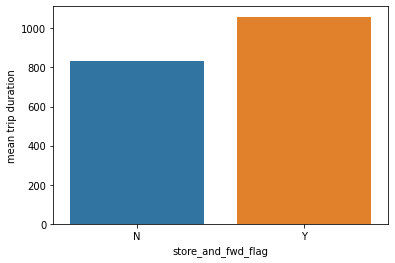

In [77]:
sfflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()
sns.barplot(sfflag.index,sfflag.values)
plt.ylabel('mean trip duration');

Il datset è fortemente sbilanciato rispetto alla variabile 'store_and_fwd_flag'. Supponiamo però che questa variabile non influisca eccessivamente sulla variabile target in quanto ipotizziamo che la connessione al server sia incorrelata con la durata del viaggio.

In [78]:
#One-hot encoding
train = pd.concat([train, pd.get_dummies(train['store_and_fwd_flag'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['store_and_fwd_flag'])], axis=1)

train.drop(['store_and_fwd_flag'], axis=1, inplace=True)
test.drop(['store_and_fwd_flag'], axis=1, inplace=True)

## SPEED
Is the trip duration time-dependent?
https://www.kaggle.com/pirsqrd/predictingtripduration

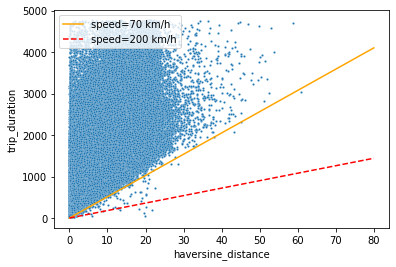

In [79]:
sns.scatterplot(x='haversine_distance', y='trip_duration', data=train, s=5)
plt.plot([0,80],[0,4100], color='orange', label='speed=70 km/h')
plt.plot([0,80], [0,1440], color='red', linestyle='dashed', label='speed=200 km/h')
plt.legend(loc='upper left');

Sembra esserci una soglia minima di tempo al di sotto della quale una certa distanza non può essere percorsa.  
Sono presenti degli outliers che elimineremo.

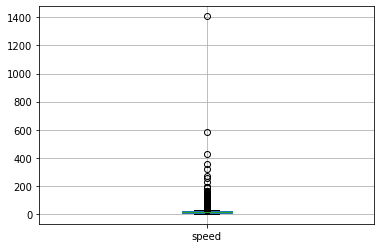

In [80]:
#Create speed feature
train['speed'] = train.haversine_distance / train.trip_duration * 3600

#Visualize speed feature
train.boxplot(column='speed', return_type='axes');

In [81]:
train[train.speed > 200].count()[0]

8

In [82]:
# Remove outliers
train = train[train.speed <= 200]

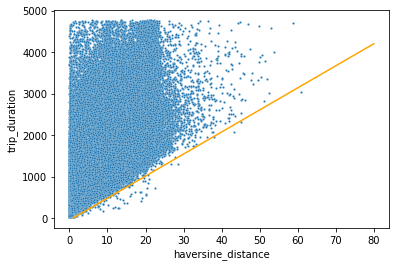

In [83]:
sns.scatterplot(x='haversine_distance',y='trip_duration', data=train, s=5)
plt.plot([1,80],[0,4200], color='orange');

#Sistemazione dataset finale

Dividiamo il dataset in train e validation.  
La proporzione del train e del validation è del 70% - 30%, così da avere un numero di elementi nel validation comparabili al numero di elementi nel test.

In [84]:
y=train['trip_duration']

In [85]:
train.drop(columns =['trip_duration', 'id', 'pickup_datetime', 'haversine_distance', 'manhattan_distance',
                     'week', 'day', 'geometry','speed', 'pickup_timezone'], inplace =True)

In [86]:
test.drop(columns =['id', 'pickup_datetime', 'haversine_distance', 'manhattan_distance','week', 'day', 'pickup_timezone'], inplace =True)

In [ ]:
train.columns==test.columns

Salvo il dataset con le nuove variabili, con gli gli outliers tolti così che non devo far rigirare tutto il codice precedente ogni volta che costruiso i modelli.

In [93]:
train.to_csv('train_final.csv')
y.to_csv('y_final.csv')

test.to_csv('test_final.csv')

# VARIO

- sarebbe meglio raggruppare per quartiere?? invece che raggruppare per zona geografica tramite kmeans?? difficult!

- https://www.kaggle.com/pirsqrd/predictingtripduration Map where the passengers have been picked up (blue) and dropped off (red)

- We can overlap datapoints to the map for getting better idea!  
https://www.kaggle.com/abhishek2mahato/newyorkcity-taxi-trip-duration-beginner-s-special

- grafico north America https://www.kaggle.com/billymwas/notebooka7204da42c

- grafico con le 3 distanze a confronto

- si potrebbe calcolare la distanza tramite google maps!! https://it.coredump.biz/questions/45479728/calculate-distance-between-2-points-in-google-maps-using-python
https://pypi.org/project/geopy/

- AGGIUNGI LEGENDA SCATTER!!!!! dividere giornata tramite kmeans   
https://github.com/Currie32/NYC-Taxi-Trip-Duration/blob/master/notebook.ipynb

- manca tabella correlazioni!!!!!

- https://www.kaggle.com/neomatrix369/chaieda-nyc-taxi-trip-duration-data-prep divide in quartieri, molto bello!!! fai!
https://www.kaggle.com/neomatrix369/chaieda-nyc-taxi-trip-duration-analysis (QUI TUTTE LE VISUALIZZAZIONI legate ai quartieri! non c'è il codice però idee interessanti! fai se hai tempo!)

- There is a relation between trip distance and trip duration. non ho capito grafico, capisci!!! https://www.kaggle.com/billymwas/notebooka7204da42c

- Function aiming at calculating the direction (cioè angolo in gradi. ha senso??) https://www.kaggle.com/jinbonnie/subfinal  

- prendi spunto ma codice è in R!! https://www.kaggle.com/natalia1312/exploratory-data-analysis-ny-taxi-trip-duration

- CODICE ALTRI TIPI!!! https://github.com/Currie32/NYC-Taxi-Trip-Duration/blob/master/notebook.ipynb

- modo con seno e coseno per calcolare distanze! https://www.kaggle.com/soheilhosseini/new-york-city-taxi-trip-duration-xgboost

- iper completo con grfici geografici molto belli  
https://www.kaggle.com/abhishek2mahato/newyorkcity-taxi-trip-duration-beginner-s-special

- Feature Importance after Modeling  
https://www.kaggle.com/jeffreycbw/nyc-taxi-trip-public-0-37399-private-0-37206

- altri grfici geografici iperbelli (+ Clustering + Temporal and geospatial aggregation + Feature importance analysis + grafico rmse without feature)
https://www.kaggle.com/liuxun801/from-eda-to-the-top-lb-0-367

- grafici carini https://www.kaggle.com/ahmedmurad1990/nyc-taxi

- vario, niente di che https://www.kaggle.com/yanstoyanov/lab-4

- vario da riguardare https://www.kaggle.com/pirsqrd/predictingtripduration

- boh.. https://www.kaggle.com/bibhudas/geospatial-data-fare-optimization

In [ ]:
plt.figure(figsize=(20, 20))
sns.pairplot(X_train, diag_kind="hist", height=5)

In [ ]:
import urllib
plt.figure(figsize=(10,8))
#loading the png NYC image found on Google and saving to my local folder along with the project
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
nyc_img=plt.imread(i)
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

X.plot(kind='scatter', x='longitude', y='latitude', ax=ax, 
           cmap=plt.get_cmap('jet'), alpha=0.7, zorder=5)

plt.legend()
plt.show()

#tolto, inutile!!!!!!

In [ ]:
#non è granchè e non serve.. cose già dette
fig, sub = plt.subplots(3,1,figsize=(10, 10))
counter = 0

for feat, subplot in zip(["month","day","hour","month","day","hour"], sub.flatten()):
    if counter<3:
        sns.barplot(x=train[feat].value_counts().index, y = train[feat].value_counts().values, ax= subplot, palette="CMRmap")
        subplot.grid()
        subplot.set_title("Train set {}".format(feat))
    counter+=1
    
fig.tight_layout()